# Check offline 

Here we check how the ML model trained using MITgcm does on MOM6 data by comparing against diagnosed subgrid forcing.  

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree
import xgcm
import optax
from flax.training import train_state
from flax.training import checkpoints

In [2]:
import sys
sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [3]:
data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day/'

ds_50km = xr.open_zarr(f'{data_bucket}ml_data_'+'50'+'km.zarr')
ds_100km = xr.open_zarr(f'{data_bucket}ml_data_'+'100'+'km.zarr')
ds_200km = xr.open_zarr(f'{data_bucket}ml_data_'+'200'+'km.zarr')
ds_400km = xr.open_zarr(f'{data_bucket}ml_data_'+'400'+'km.zarr')

### Load and setup ANN

In [4]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  'Sx', 'Sy', 'Lfilt']

In [5]:
size_name = 'large'
layer_sizes = [64, 64, 2]

model, params = ml_hf.initialize_model(layer_sizes, len(input_channels) )

learning_rate = .01
tx = optax.adam(learning_rate=learning_rate)

state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

# Read back from the checkpoint
CKPT_DIR = '../train_models/ckpts_single_all_res_large'
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

In [6]:
#state.params['params']['layers_0']['bias']

In [7]:
ANN_nc = xr.open_dataset('../train_models/ann_params_all_res_large.nc')

### Setup input and output data

In [8]:
L = 100.
ds_L = ds_100km

In [9]:
def ANN_pred(ds_L, L):
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    choice = 0 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl') * 0.
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl') * 0.
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl') * 0.
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl') * 0.
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    input_norms = ANN_nc.input_norms.rename({'input':'variable'})
    output_norms = ANN_nc.output_norms.rename({'output':'variable'})
    
    ds_test_small = ds_test.isel(Time=slice(340,None)).sel(yh=slice(L, 1600-L))
    
    ds_input = ds_test_small[input_channels].to_array().transpose(...,'variable')/input_norms
    
    ds_output = ds_test_small[output_channels].to_array().transpose(...,'variable')#/output_norms
    
    x0 = np.zeros(7)
    x0[6] = L/input_norms[6]
    y_0 = state.apply_fn(state.params, x0)
    y_0
    
    y_pred = state.apply_fn(state.params, ds_input) 
    
    ds_pred = xr.DataArray(y_pred, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    ds_pred_no_bias = xr.DataArray(y_pred-y_0, dims = ds_output.dims, coords = ds_output.coords)*output_norms
    
    return ds_output, ds_pred_no_bias, ds_pred

In [10]:
ds_output_50km, ds_pred_no_bias_50km, ds_pred_50km = ANN_pred(ds_50km, 50.)
ds_output_100km, ds_pred_no_bias_100km, ds_pred_100km = ANN_pred(ds_100km, 100.)
ds_output_200km, ds_pred_no_bias_200km, ds_pred_200km = ANN_pred(ds_200km, 200.)
ds_output_400km, ds_pred_no_bias_400km, ds_pred_400km = ANN_pred(ds_400km, 400.)

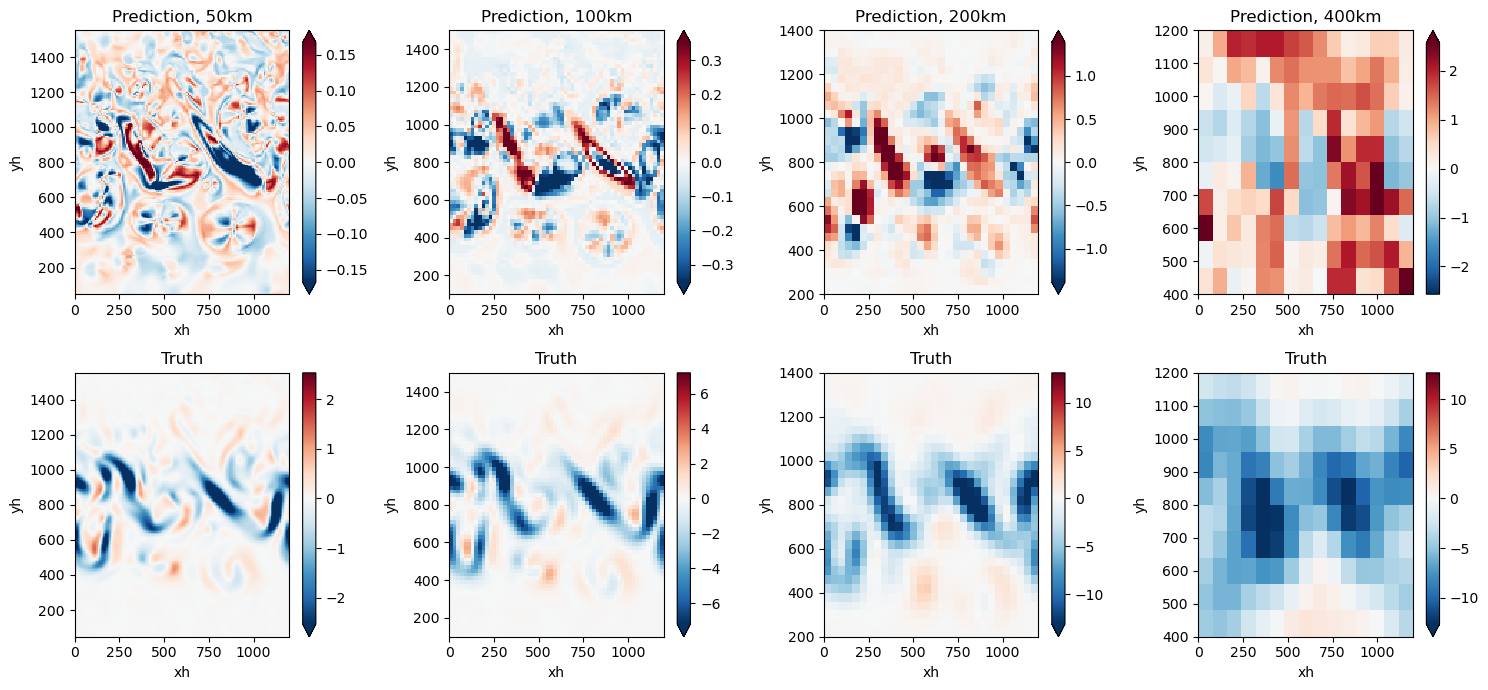

In [11]:
plt.figure(figsize=(15,7))

vmin = -1
idT = 2
robust=True

plt.subplot(241)
ds_pred_no_bias_50km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 50km')

plt.subplot(245)
ds_output_50km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.subplot(242)
ds_pred_no_bias_100km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 100km')

plt.subplot(246)
ds_output_100km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')


plt.subplot(243)
ds_pred_no_bias_200km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 200km')

plt.subplot(247)
ds_output_200km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.subplot(244)
ds_pred_no_bias_400km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 400km')

plt.subplot(248)
ds_output_400km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.tight_layout()

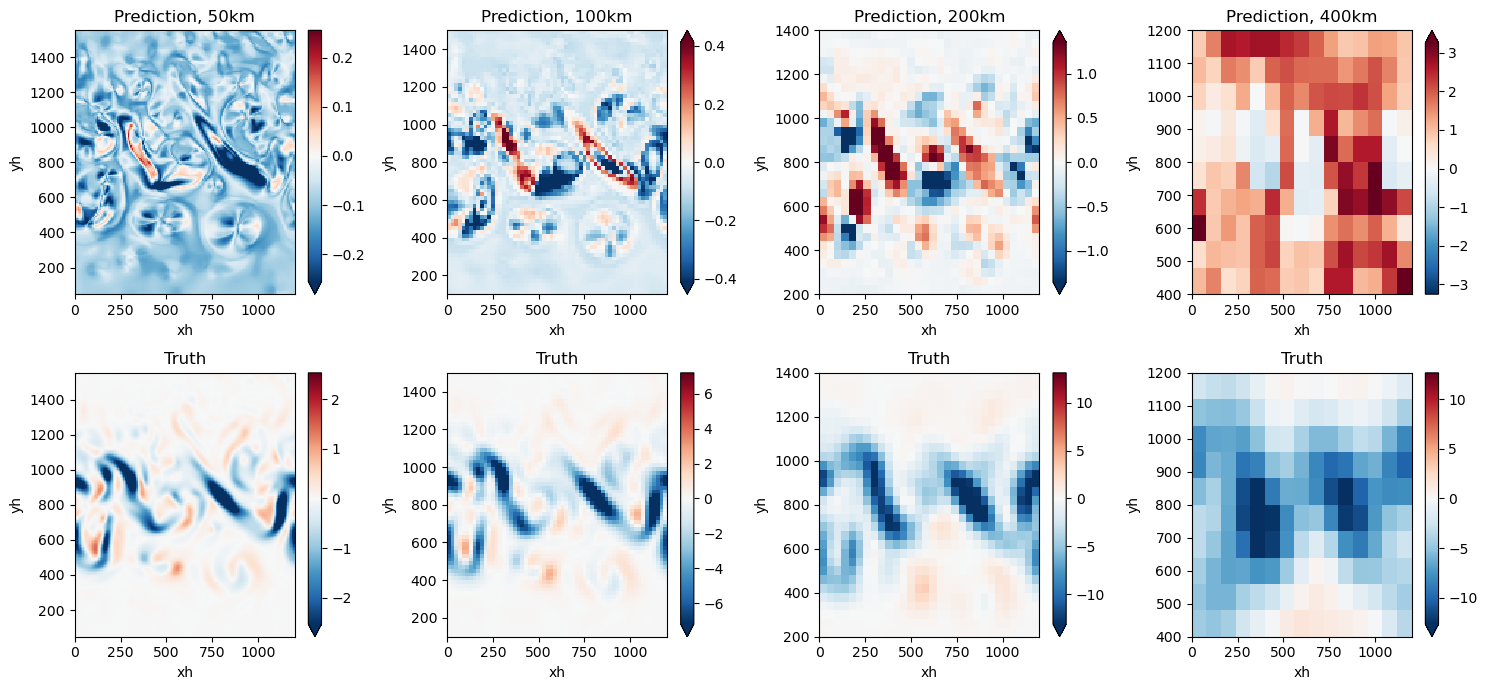

In [12]:
plt.figure(figsize=(15,7))

vmin = -1
idT = 2
robust=True

plt.subplot(241)
ds_pred_50km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 50km')

plt.subplot(245)
ds_output_50km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.subplot(242)
ds_pred_100km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 100km')

plt.subplot(246)
ds_output_100km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')


plt.subplot(243)
ds_pred_200km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 200km')

plt.subplot(247)
ds_output_200km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.subplot(244)
ds_pred_400km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Prediction, 400km')

plt.subplot(248)
ds_output_400km.sel(variable='Sfny').isel(Time=idT).plot(robust=robust)
plt.title('Truth')

plt.tight_layout()

In [13]:
def compute_SS_Vbar(ds):
    dx = ds.xh.diff('xh')[0].values*1e3
    m3_to_Sv = 1e-6
    
    #ds_filt['Vbar_LS'] = ds_filt['vbar_hbar'].sum('xh')*m3_to_Sv*dx
    Vbar_SS = -ds.sel(variable='Sfny').sum('xh').mean('Time')*m3_to_Sv*dx
    
    return Vbar_SS

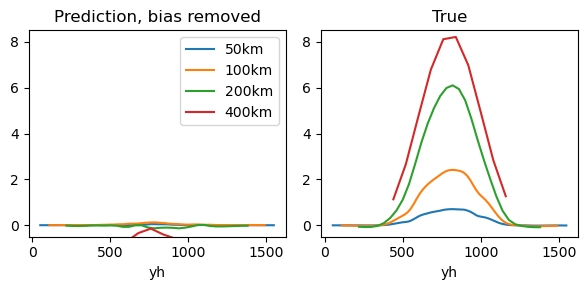

In [14]:
plt.figure(figsize=(6,3))

plt.subplot(121)
compute_SS_Vbar(ds_pred_no_bias_50km).plot(label='50km')
compute_SS_Vbar(ds_pred_no_bias_100km).plot(label='100km')
compute_SS_Vbar(ds_pred_no_bias_200km).plot(label='200km')
compute_SS_Vbar(ds_pred_no_bias_400km).plot(label='400km')
plt.legend()
plt.ylim([-.5, 8.5])
plt.title('Prediction, bias removed')

plt.subplot(122)
compute_SS_Vbar(ds_output_50km).plot()
compute_SS_Vbar(ds_output_100km).plot()
compute_SS_Vbar(ds_output_200km).plot()
compute_SS_Vbar(ds_output_400km).plot()
plt.title('True')
plt.ylim([-.5, 8.5])

plt.tight_layout()

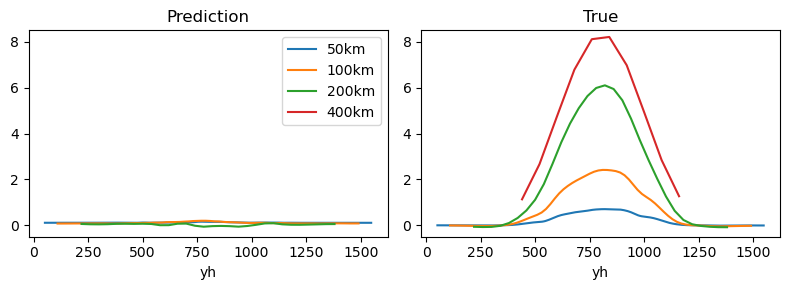

In [15]:
plt.figure(figsize=(8,3))

plt.subplot(121)
compute_SS_Vbar(ds_pred_50km).plot(label='50km')
compute_SS_Vbar(ds_pred_100km).plot(label='100km')
compute_SS_Vbar(ds_pred_200km).plot(label='200km')
compute_SS_Vbar(ds_pred_400km).plot(label='400km')
plt.legend()
plt.ylim([-.5, 8.5])
plt.title('Prediction')

plt.subplot(122)
compute_SS_Vbar(ds_output_50km).plot()
compute_SS_Vbar(ds_output_100km).plot()
compute_SS_Vbar(ds_output_200km).plot()
compute_SS_Vbar(ds_output_400km).plot()
plt.title('True')
plt.ylim([-.5, 8.5])

plt.tight_layout()